<a href="https://colab.research.google.com/github/JKJIN1999/LeNet5_CIFAR10/blob/main/LeNet5_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LeNet5 for CIFAR dataset**
### This project will explain how to build up a LeNet5 for CIFAR dataset

### *Must set the runtime to GPU!* 


### The process will be as 
1.  Import requirements
2.  Download CIFAR dataset and preprocessing
3.  Create LeNet5 model for CIFAR10 
4.  Initialize Training, Evaluating process
5.  Train the Model and Test
6.  
7.  




## 1. Import requirements

In [117]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import random
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler



## 2. Download CIFAR dataset and preprocessing

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Image Tensor
tensor([[[-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
         [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
         [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
         ...,
         [-1.9895, -1.9895, -1.9895,  ...,  1.6939,  1.5828,  1.5987],
         [-1.9895, -1.9895, -1.9895,  ...,  1.5669,  1.4875,  1.5352],
         [-1.9895, -1.9895, -1.9895,  ...,  1.6939,  1.6304,  1.6304]],

        [[-1.9844, -1.9844, -1.9844,  ..., -1.9844, -1.9844, -1.9844],
         [-1.9844, -1.9844, -1.9844,  ..., -1.9844, -1.9844, -1.9844],
         [-1.9844, -1.9844, -1.9844,  ..., -1.9844, -1.9844, -1.9844],
         ...,
         [-1.9844, -1.9844, -1.9844,  ...,  1.6144,  1.4531,  1.5015],
         [-1.9844, -1.9844, -1.9844,  ...,  1.5983,  1.4369,  1.4531],
         [-1.9844, -1.9844, -1.9844,  ...,  1.7435,  1.6629,  1.6144]],

        [[-1.7107, -1.7107, -1.7107,  ..., -1.7107, -1.7107, -1.7107],
         [-1.7107, -1.710

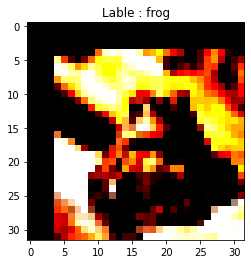

In [118]:
# data image horizontal & Vertical flippping and padding the image for random cropping (delete the horizontal flip if you desire)
transforms_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # the arguments inside the normalization is the mean and standard deviation value specifically for CIFAR dataset (https://github.com/kuangliu/pytorch-cifar/issues/19)
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  
])

transforms_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  
])

train_validation_data = torchvision.datasets.CIFAR10(root='./dataset/', train=True, transform=transforms_train, download=True)
train_data, validation_data = torch.utils.data.random_split(train_validation_data, [40000, 10000])
test_data = dsets.CIFAR10(root='./dataset/', train=False, transform=transforms_test, download=True)

train_loader = DataLoader(dataset = train_data, batch_size = 64, shuffle = True)
validation_loader = DataLoader(dataset = validation_data, batch_size = 64, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size = 64, shuffle=False )

# Classify Labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
rand = random.randint(0,500)
image, label = train_data[rand]

print("Sample Image Tensor")
print(image)
print("Shape of this image is : {}".format(image.shape))
# need to transpose the image matrix since the shape is changed from tensor for training
plt.imshow(np.transpose(image, (1,2,0)))
plt.title("Lable : {}".format(classes[label]))
plt.show()


In [119]:
# Check the number of dataset 
print("Training Data size : {}".format(len(train_data)))
print("Validation Data size : {}".format(len(validation_data)))
print("Testing Data size : {}".format(len(test_data)))

print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Training Data size : 40000
Validation Data size : 10000
Testing Data size : 10000
True
cuda


## 3. Create LeNet5 for CIFAR10 model

In [120]:
batch_size = 128

class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Conv2d(3, 6, kernel_size = 5)
    self.layer2 = nn.Conv2d(6, 16, kernel_size = 5)
    self.layer3 = nn.Linear(400, 120)
    self.layer4 = nn.Linear(120, 84)
    self.layer5 = nn.Linear(84, 10)
    self.avg_pool = nn.AvgPool2d(2,2)
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()


  def forward(self, x):
    out = self.layer1(x)
    out = self.tanh(out)
    out = self.avg_pool(out)
    out = self.layer2(out)
    out = self.tanh(out)
    out = self.avg_pool(out)
    out = self.layer3(out.view(out.size(0), -1))
    out = self.relu(out)
    out = self.layer4(out)
    out = self.relu(out)
    out = self.layer5(out)

    return out

# Hyper_Parameters
learning_rate = 0.001

model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001,  momentum=0.9, weight_decay=1e-04)



## 4. Initialize Training, Evaluation process


In [121]:
def train(train_loader, model, criterion, optimizer):
  loss_array = []
  model.train()

  # enumerate is a built-in function for python where you can use both the index and the value from list or array through each loop
  for i ,(image, label) in enumerate(train_loader):
    optimizer.zero_grad()
    image = image.to(device)
    label = label.to(device)

    output = model(image)
    loss = criterion(output, label)
    loss_array.append(loss.item())
    loss.backward()
    optimizer.step()

    # Evaluating each 100 steps within 64 batch-size. Thus, after training 6400 images, this will print out
    if (i+1) % 100 == 0:
      print('Average Loss for {} iteration is : {}'.format( i+1 , sum(loss_array)/len(loss_array)))
      loss_array = []

def evaluation(validation_loader, model):
  model.eval()
  correct = 0
  total = 0

  for i , (image, label) in enumerate(validation_loader):
    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
      output = model(image)
      _ , predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()
      total += label.size(0)

  return correct/total




### Why we use both model.eval(), torch.with no_grad() 
1. model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
2. torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).

## 5. Train Model and Test

In [ ]:
for  _ in range(1000):
  train(train_loader, model, criterion, optimizer)
  accuracy = evaluation(validation_loader, model)
  print('Evaluation Accuracy is : {}'.format(accuracy))

test_acc = evaluation(test_loader, model)
print('Test Accuracy is : {}'.format(test_acc))

Average Loss for 100 iteration is : 1.9936450028419495
Average Loss for 200 iteration is : 1.9896110343933104
Average Loss for 300 iteration is : 1.9764859187602997
Average Loss for 400 iteration is : 1.965882362127304
Average Loss for 500 iteration is : 1.9338435745239257
Average Loss for 600 iteration is : 1.9402586615085602
Evaluation Accuracy is : 0.2866
Average Loss for 100 iteration is : 1.9254053580760955
Average Loss for 200 iteration is : 1.9123211848735808
Average Loss for 300 iteration is : 1.9130331254005433
Average Loss for 400 iteration is : 1.8975920808315276
Average Loss for 500 iteration is : 1.886900645494461
Average Loss for 600 iteration is : 1.8860277366638183
Evaluation Accuracy is : 0.3178
Average Loss for 100 iteration is : 1.8901944088935851
Average Loss for 200 iteration is : 1.861287739276886
Average Loss for 300 iteration is : 1.8687576150894165
Average Loss for 400 iteration is : 1.8627811574935913
Average Loss for 500 iteration is : 1.841053568124771
Avera